In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data from csv file
df = pd.read_csv('/content/sample_data/suicidal_ideation_detection_reddit_dataset.csv')
df.head()

,Title,Post,Label
0,I'm looking for a girl I've met at the Polish ...,I've tried Polish spotted pages but I guess sh...,Non-Suicidal
1,I got a guy kicked off a domestic flight today.,I was in a forward row as we were boarding for...,Non-Suicidal
2,"My youngest got in school suspension, I’m so p...",So according to witness testimonies a boy grab...,Non-Suicidal
3,"I'm a cashier who switched from ""sir/mam"" to ""...","So as said in the title, I'm a cashier (well, ...",Non-Suicidal
4,My whole class complimented me and didn’t real...,"Today in class, we were doing this activity ca...",Non-Suicidal


# Exploratory Data Analysis

In [3]:
# Shape of data
df.shape
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset contains 15477 rows and 3 columns.


In [4]:
# Check data types
print(df.dtypes)

Title    object
Post     object
Label    object
dtype: object


In [5]:
# Check for null values
print(df.isnull().sum())

Title       0
Post     1234
Label       0
dtype: int64


In [6]:
# Fill missing 'Post' values with the corresponding 'Title' (if available)
df['Post'] = df['Post'].fillna(df['Title'])

# Verify that missing values are handled
missing_values_after = df.isnull().sum()
print(missing_values_after)

Title    0
Post     0
Label    0
dtype: int64


In [7]:
# Change heading to lowercase
df.columns = df.columns.str.lower()

In [8]:
# Convert labels to lowercase
df['label'] = df['label'].str.lower()

# Check unique labels
unique_labels = df['label'].unique()
print('Unique labels below cleaning:')
print(unique_labels)

# Drop the row where the label is 'label'
df = df[df['label'] != 'label']
print('Unique labels after cleaning:')
print(df['label'].unique())

Unique labels below cleaning:
['non-suicidal' 'label' 'suicidal']
Unique labels after cleaning:
['non-suicidal' 'suicidal']


label
non-suicidal    52.991729
suicidal        47.008271
Name: proportion, dtype: float64


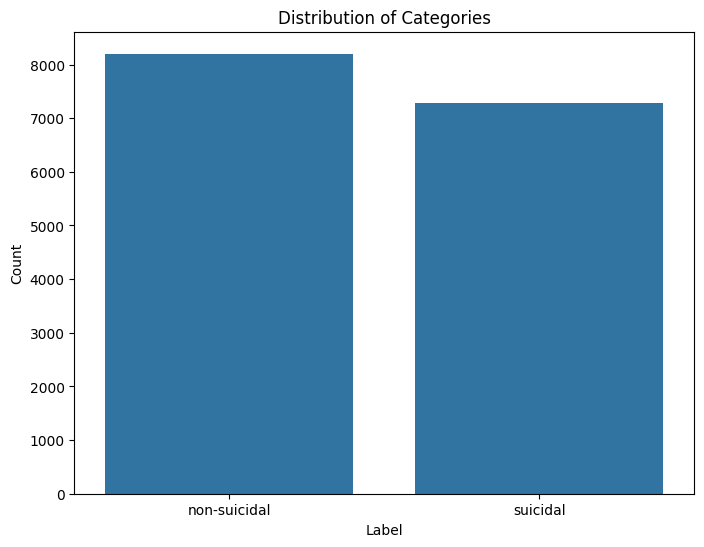

In [9]:
# Check class distribution
class_distribution = df['label'].value_counts(normalize=True) * 100
print(class_distribution)

# Count plot
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Categories')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

The class distribution is quite balanced.

## Message Length Distribution

* Suicidal messages tend to be slightly longer than non-suicidal messages.
* Non-suicidal messages are usually shorter and more concentrated around lower character counts.




         word_count    char_count
count  15476.000000  15476.000000
mean     133.910119    693.892414
std      167.884272    870.622612
min        1.000000      1.000000
25%       39.000000    198.750000
50%       85.000000    438.000000
75%      169.000000    877.000000
max     4185.000000  19250.000000


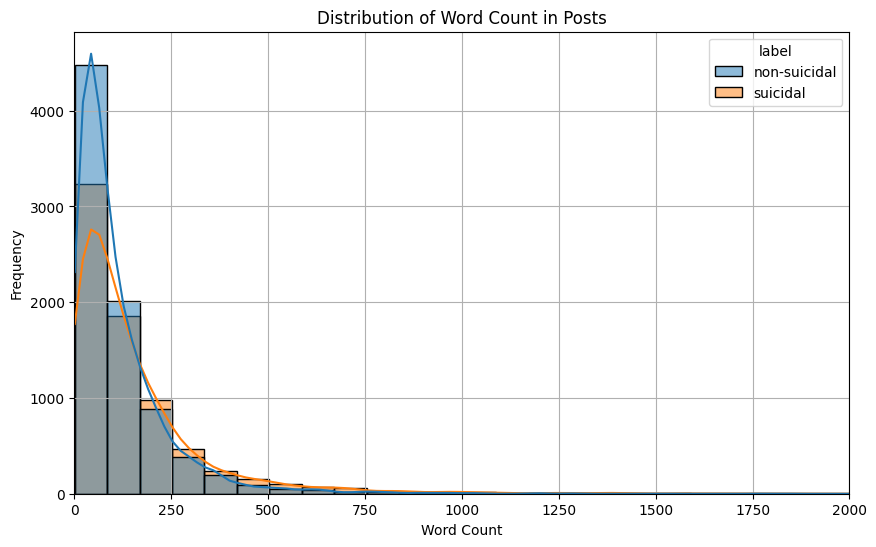

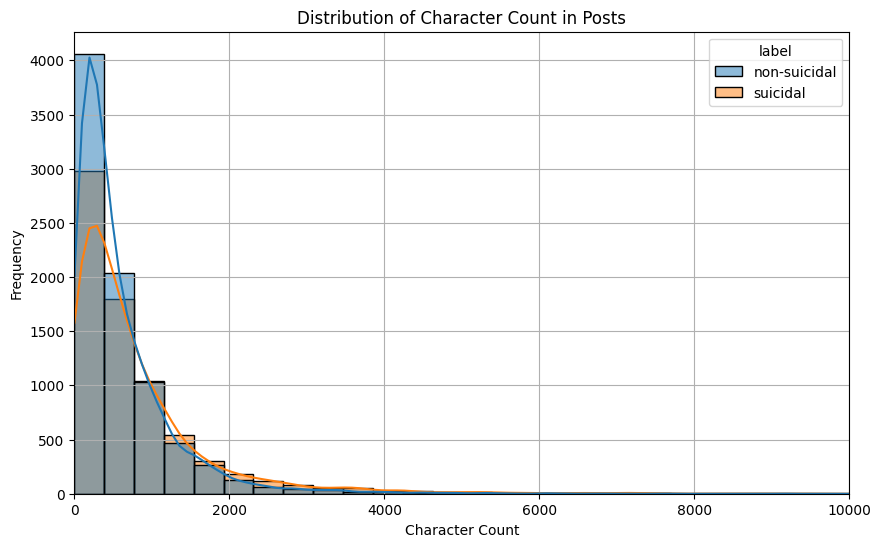

In [10]:
# Add word and character count columns
df['word_count'] = df['post'].apply(lambda x: len(x.split()))
df['char_count'] = df['post'].apply(lambda x: len(x))

# Summary statistics
print(df[['word_count', 'char_count']].describe())

# Plot word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', bins=50, kde=True, hue='label')
plt.title('Distribution of Word Count in Posts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim([0,2000])
plt.grid(True)
plt.show()

# Plot character count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='char_count', bins=50, kde=True, hue='label')
plt.title('Distribution of Character Count in Posts')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.xlim([0,10000])
plt.grid(True)
plt.show()

## Most Common Words

In [11]:
# Merge title and posts
df['text'] = df['title'] + " " + df['post'].fillna("")
df = df.drop(columns=['title', 'post'])
print(df.head())

          label  word_count  char_count  \
0  non-suicidal         215        1060   
1  non-suicidal         192         945   
2  non-suicidal          71         367   
3  non-suicidal         480        2539   
4  non-suicidal         175         894   

                                                text  
0  I'm looking for a girl I've met at the Polish ...  
1  I got a guy kicked off a domestic flight today...  
2  My youngest got in school suspension, I’m so p...  
3  I'm a cashier who switched from "sir/mam" to "...  
4  My whole class complimented me and didn’t real...  


In [12]:
# Import libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import string

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Initialize Stemmer & Lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define text cleaning function
def clean_text(text):
  if pd.isnull(text): # Handle NaN values
    return ""
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
  text = re.sub(r'\@\w+|\#', '', text) # Remove mentions and hashtags
  text = re.sub(r'[^\w\s]', '', text) # Remove special characters
  text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
  text = re.sub(r'\d+', '', text)   # Remove numbers
  return text

# Tokenization, stopword removal, stemming & lemmatization
def preprocess_text(text):
  words = text.split()  # Tokenization
  words = [word for word in words if word not in stop_words] # Remove stopwords
  words = [stemmer.stem(word) for word in words] # Stemming
  words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
  return " ".join(words)

In [14]:
# Apply cleaning, tokenization, and processing
df['cleaned_text'] = df['text'].apply(clean_text).apply(preprocess_text)
df.head(10)

,label,word_count,char_count,text,cleaned_text
0,non-suicidal,215,1060,I'm looking for a girl I've met at the Polish ...,im look girl ive met polish airport thank prop...
1,non-suicidal,192,945,I got a guy kicked off a domestic flight today...,got guy kick domest flight today forward row b...
2,non-suicidal,71,367,"My youngest got in school suspension, I’m so p...",youngest got school suspens im proud accord wi...
3,non-suicidal,480,2539,"I'm a cashier who switched from ""sir/mam"" to ""...",im cashier switch sirmam dear notic someth won...
4,non-suicidal,175,894,My whole class complimented me and didn’t real...,whole class compliment didnt realiz today clas...
5,non-suicidal,474,2545,Americans don’t seem real and it boggles my mi...,american dont seem real boggl mind fact real a...
6,non-suicidal,337,1719,I blew my dad's mind by being a good landlord....,blew dad mind good landlord im consid older mi...
7,non-suicidal,89,426,I look so much like my father that my face unl...,look much like father face unlock phone imagin...
8,non-suicidal,123,633,I broke a pay-it-forward chain that had been g...,broke payitforward chain go morn drive new ham...
9,non-suicidal,256,1393,I'm a man in a women dominated space and I fee...,im man woman domin space feel realli safe hi s...


In [15]:
# Top 20 most common words based on TFIDF score

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20)  # Extract top 20 features

# Fit and transform the data for suicidal
tfidf_matrix_suicidal = tfidf.fit_transform(df[df['label'] == 'suicidal']['cleaned_text'])

# Get feature names and their importance scores for suicidal
feature_names = tfidf.get_feature_names_out()
tfidf_scores_suicidal = tfidf_matrix_suicidal.sum(axis=0).tolist()[0]  # Sum of TF-IDF scores for each word

# Combine words and scores for suicidal
tfidf_results_suicidal = sorted(zip(feature_names, tfidf_scores_suicidal), key=lambda x: x[1], reverse=True)

# Fit and transform the data for non-suicidal
tfidf_matrix_nonsuicidal = tfidf.fit_transform(df[df['label'] == 'non-suicidal']['cleaned_text'])

# Get feature names and their importance scores for non-suicidal
feature_names = tfidf.get_feature_names_out()
tfidf_scores_nonsuicidal = tfidf_matrix_nonsuicidal.sum(axis=0).tolist()[0]  # Sum of TF-IDF scores for each word

# Combine words and scores for nonsuicidal
tfidf_results_nonsuicidal = sorted(zip(feature_names, tfidf_scores_nonsuicidal), key=lambda x: x[1], reverse=True)

# Display the top 20 important words based on TF-IDF scores
print('Top 20 Important Words for Suicidal Messages:')
for word, score in tfidf_results_suicidal[:20]:
    print(f'{word}: {score:.1f}')
print('\nTop 20 Important Words for Non-suicidal Messages:')
for word, score in tfidf_results_nonsuicidal[:20]:
    print(f'{word}: {score:.1f}')

Top 20 Important Words for Suicidal Messages:
im: 1829.5
want: 1186.1
dont: 1161.3
feel: 1094.3
like: 953.2
life: 949.7
get: 856.8
cant: 836.3
go: 833.6
know: 753.9
ive: 738.9
peopl: 703.8
fuck: 689.5
think: 655.8
live: 655.6
time: 635.3
even: 631.7
one: 629.9
die: 600.8
tri: 589.0

Top 20 Important Words for Non-suicidal Messages:
im: 1599.0
like: 1067.2
time: 920.4
get: 910.0
year: 901.4
ive: 881.2
feel: 874.8
day: 837.6
got: 826.3
today: 807.4
go: 771.6
one: 765.5
realli: 727.3
work: 667.3
dont: 643.6
know: 637.0
want: 635.0
peopl: 623.0
make: 621.9
thing: 595.8


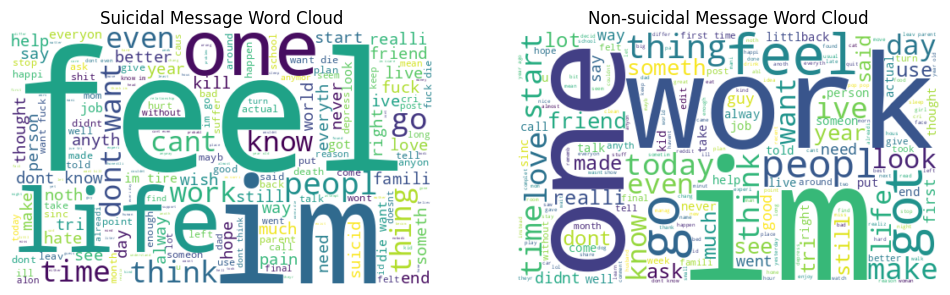

In [16]:
from wordcloud import WordCloud
from collections import Counter

# Generate word clouds for suicidal and non-suicidal messages
suicidal_wc = WordCloud(width=500, height=300, background_color='white').generate(df[df['label'] == 'suicidal']['cleaned_text'].str.cat(sep=' '))
nonsuicidal_wc = WordCloud(width=500, height=300, background_color='white').generate(df[df['label'] == 'non-suicidal']['cleaned_text'].str.cat(sep=' '))

# Plot the word clouds
plt.figure(figsize=(12, 5))

# Suicidal Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(suicidal_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Suicidal Message Word Cloud')

# Non-suicidal Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(nonsuicidal_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Non-suicidal Message Word Cloud')

plt.show()

In [17]:
# Top 20 most common bigrams

from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer for bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20)  # Extract top 20 bigrams

# Fit and transform the cleaned text data for suicidal
bigram_matrix_suicidal = bigram_vectorizer.fit_transform(df[df['label'] == 'suicidal']['cleaned_text'])

# Get bigram feature names and their counts for suicidal
bigram_names_suicidal = bigram_vectorizer.get_feature_names_out().tolist()  # Convert to list
bigram_counts_suicidal = bigram_matrix_suicidal.sum(axis=0).A1  # Convert to 1D array

# Combine bigrams and their counts for suicidal
bigram_results_suicidal = dict(zip(bigram_names_suicidal, bigram_counts_suicidal))

# Fit and transform the cleaned text data for non-suicidal
bigram_matrix_nonsuicidal = bigram_vectorizer.fit_transform(df[df['label'] == 'non-suicidal']['cleaned_text'])

# Get bigram feature names and their counts for non-suicidal
bigram_names_nonsuicidal = bigram_vectorizer.get_feature_names_out().tolist()  # Convert to list
bigram_counts_nonsuicidal = bigram_matrix_nonsuicidal.sum(axis=0).A1  # Convert to 1D array

# Combine bigrams and their counts for non-suicidal
bigram_results_nonsuicidal = dict(zip(bigram_names_nonsuicidal, bigram_counts_nonsuicidal))

# Display the top 20 bigrams for suicidal messages
print('Top 20 Bigrams for Suicidal Messages:')
for bigram, count in sorted(bigram_results_suicidal.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f'{bigram}: {count}')

print('\nTop 20 Bigrams for Non-suicidal Messages:')
for bigram, count in sorted(bigram_results_nonsuicidal.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f'{bigram}: {count}')

Top 20 Bigrams for Suicidal Messages:
feel like: 2690
dont want: 1991
dont know: 1739
im tire: 1007
die want: 975
want fuck: 909
want die: 905
fuck die: 892
get better: 861
im go: 720
like im: 655
dont think: 513
dont even: 503
know im: 493
wanna die: 460
wish could: 458
everi day: 452
im sorri: 446
im scare: 420
year old: 418

Top 20 Bigrams for Non-suicidal Messages:
feel like: 1020
first time: 747
dont know: 479
pop pop: 459
year ago: 427
year old: 414
im go: 352
anyon el: 348
im happi: 317
im proud: 294
last night: 279
im realli: 276
ive never: 275
edit thank: 273
even though: 261
thank much: 250
felt like: 242
last year: 241
like im: 235
everi day: 225


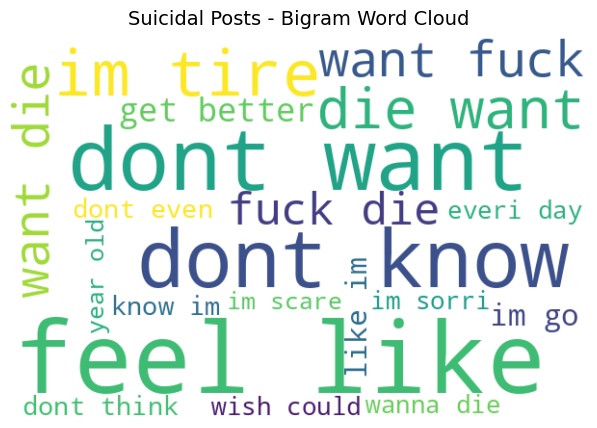

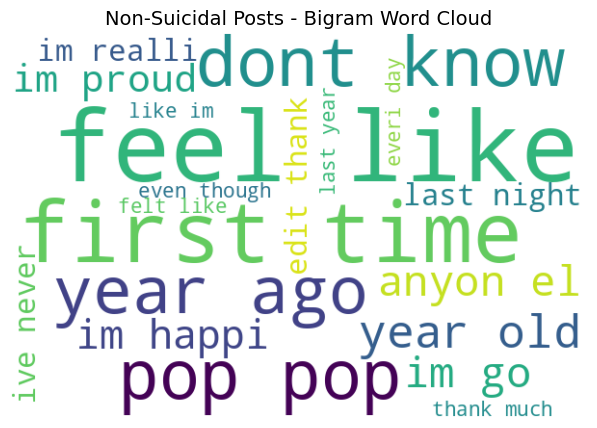

In [18]:
# Create wordcloud for bigram

# Function to generate and display word cloud
def plot_wordcloud(bigram_dict, title):
    wordcloud = WordCloud(width=600, height=400, background_color="white").generate_from_frequencies(bigram_dict)

    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Plot word clouds
plot_wordcloud(bigram_results_suicidal, "Suicidal Posts - Bigram Word Cloud")
plot_wordcloud(bigram_results_nonsuicidal, "Non-Suicidal Posts - Bigram Word Cloud")

* Suicidal messages contain phrases expressing despair (“want die”, “im tire”) and helplessness (“dont want”, “im scare”).
* Non-suicidal messages contain more diverse topics, with references to personal achievements, gratitude, general life events, etc.


## Sentiment analysis

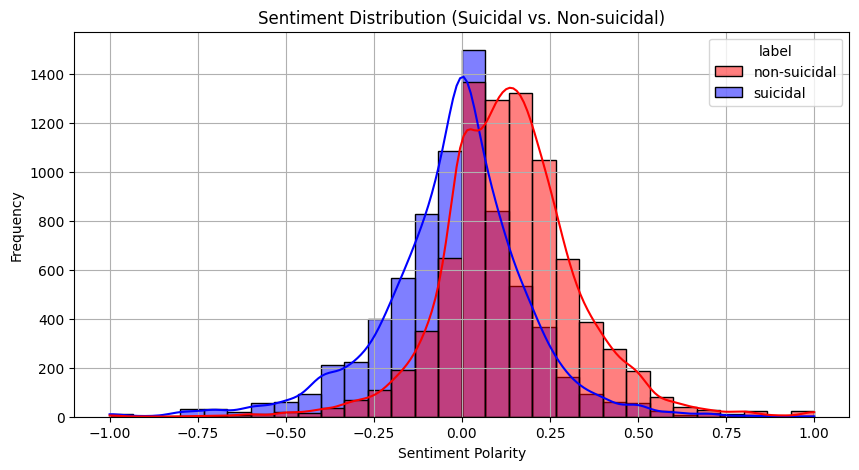

label
non-suicidal    0.138042
suicidal       -0.022303
Name: sentiment, dtype: float64


In [19]:
# Predict sentiment

from textblob import TextBlob

# Function to get sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis
df['sentiment'] = df['text'].apply(get_sentiment)

# Plot sentiment distribution for spam and ham messages
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='sentiment', hue='label', bins=30, kde=True, palette={'suicidal': 'blue', 'non-suicidal': 'red'})
plt.title('Sentiment Distribution (Suicidal vs. Non-suicidal)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Get average sentiment per category
average_sentiment = df.groupby('label')['sentiment'].mean()
print(average_sentiment)

* Non-suicidal messages tend to have a higher sentiment score than suicidal messages.
* Suicidal messages have a mix of neutral and slightly negative tones.

# Feature Engineering

In [20]:
df.head()

,label,word_count,char_count,text,cleaned_text,sentiment
0,non-suicidal,215,1060,I'm looking for a girl I've met at the Polish ...,im look girl ive met polish airport thank prop...,-0.147024
1,non-suicidal,192,945,I got a guy kicked off a domestic flight today...,got guy kick domest flight today forward row b...,0.049495
2,non-suicidal,71,367,"My youngest got in school suspension, I’m so p...",youngest got school suspens im proud accord wi...,0.253125
3,non-suicidal,480,2539,"I'm a cashier who switched from ""sir/mam"" to ""...",im cashier switch sirmam dear notic someth won...,0.137562
4,non-suicidal,175,894,My whole class complimented me and didn’t real...,whole class compliment didnt realiz today clas...,0.272650


1. Metadata Features

In [21]:
!pip install textstat
import textstat

# Readability scores
df['flesch_reading_ease'] = df['cleaned_text'].apply(textstat.flesch_reading_ease)
df['smog_index'] = df['cleaned_text'].apply(textstat.smog_index)

# Add to feature set
X_metadata = df[['word_count', 'char_count', 'flesch_reading_ease', 'smog_index']]
print(X_metadata.head())

   word_count  char_count  flesch_reading_ease  smog_index
0         215        1060               -13.79         0.0
1         192         945                -1.95         0.0
2          71         367                54.23         0.0
3         480        2539              -171.79         0.0
4         175         894                -0.93         0.0


2. Sentiment Analysis Features



In [22]:
# Sentiment polarity & subjectivity
df.drop(columns=['sentiment'], inplace=True)
df['sentiment_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Add to feature set
X_sentiment = df[['sentiment_polarity', 'sentiment_subjectivity']]
print(X_sentiment.head())

   sentiment_polarity  sentiment_subjectivity
0           -0.147024                0.503810
1            0.049495                0.261111
2            0.253125                0.775000
3            0.137562                0.488708
4            0.272650                0.565812


3. TF-IDF Vectorisation

In [23]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['cleaned_text']).toarray()
print(X_tfidf.shape)

# PCA for TF-IDF
# from sklearn.decomposition import PCA
# pca = PCA(n_components=300)
# tfidf_pca = pca.fit_transform(X_tfidf)
# print(tfidf_pca.shape)

(15476, 5000)


4. Word2Vec Embeddings

In [24]:
# Word2Vec
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Tokenize text
tokenized_text = [word_tokenize(text) for text in df['cleaned_text']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=300, window=5, min_count=2, workers=4)

def get_word2vec_vector(tokens, word_vectors):
    vectors = [word_vectors[word] for word in tokens if word in word_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word_vectors.vector_size)

X_word2vec = np.array([get_word2vec_vector(text, word2vec_model.wv) for text in tqdm(tokenized_text)])

100%|██████████| 15476/15476 [00:02<00:00, 6740.68it/s]


5. GloVe Embeddings

In [25]:
def load_glove_embeddings(filepath, embedding_dim=100):
    glove_embeddings = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    return glove_embeddings

glove_filepath = '/content/sample_data/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_filepath)

def get_glove_vector(text, embeddings, dim=100):
    words = [word for word in text if word in embeddings]
    if words:
        return np.mean(np.array([embeddings[word] for word in words]), axis=0)
    else:
        return np.zeros(dim, dtype=np.float32)

X_glove = np.vstack([get_glove_vector(text, glove_embeddings, 100) for text in tqdm(tokenized_text)])

100%|██████████| 15476/15476 [00:00<00:00, 18019.11it/s]


6. Combine All Features

In [26]:
# Combine TF-IDF, GloVe, sentiment, and metadata features
X_combined = np.hstack((X_metadata, X_sentiment, X_tfidf, X_word2vec, X_glove))
print(X_combined.shape)

(15476, 5406)


# Train Machine Learning Models

In [27]:
# Import libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_recall_curve

In [28]:
# Standardise features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_combined)

In [29]:
# Define features and target variable
X = X_scaled
df['label'] = df['label'].map({'suicidal': 1, 'non-suicidal': 0})
y = df['label']

In [30]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [31]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
}

Model: Logistic Regression
Average F1 Score (5-Fold): 0.9399
Average Recall Score (5-Fold): 0.9328
Classification Report:
{'precision': 0.9472103279190744, 'recall': 0.9328178694158076, 'f1-score': 0.9399299005948543}
Confusion Matrix:


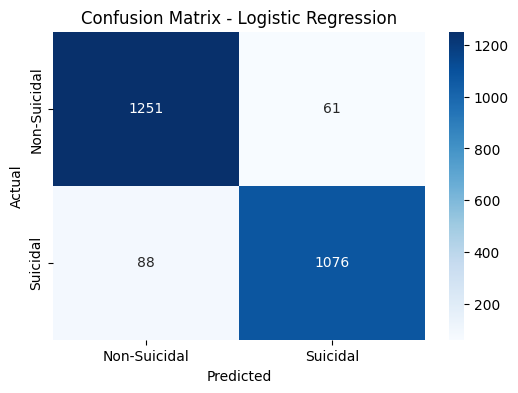

Model: Naive Bayes
Average F1 Score (5-Fold): 0.9205
Average Recall Score (5-Fold): 0.9107
Classification Report:
{'precision': 0.9305015372445, 'recall': 0.9106529209621993, 'f1-score': 0.9204538649900039}
Confusion Matrix:


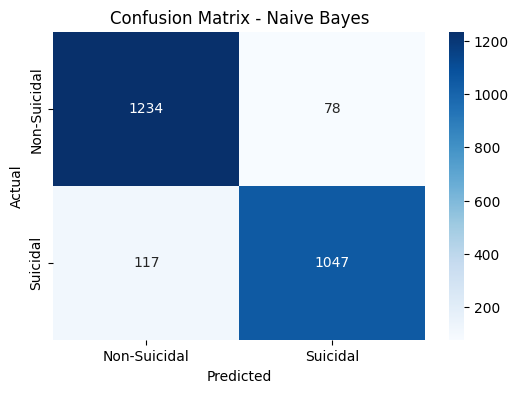

In [32]:
# Perform K-Fold Validation and Evaluate Models
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    f1_scores, recall_scores = [], []
    all_classification_report = []
    last_cm = None

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Fit the model
        model.fit(X_train_fold, y_train_fold)

        # Make predictions
        y_pred_fold = model.predict(X_test_fold)

        # Calculate F1 score & recall score
        f1 = f1_score(y_test_fold, y_pred_fold)
        f1_scores.append(f1)
        recall = recall_score(y_test_fold, y_pred_fold)
        recall_scores.append(recall)

        # Store classification report for analysis
        report = classification_report(y_test_fold, y_pred_fold, output_dict=True)
        if all_classification_report is None:
          all_classification_report = report
        else:
          all_classification_report.append(report)

        # Store last confusion matrix
        last_cm = confusion_matrix(y_test_fold, y_pred_fold)

    # Calculate mean F1 score & recall score
    mean_f1 = np.mean(f1_scores)
    mean_recall = np.mean(recall_scores)

    # Average classification report
    avg_report = {
      'precision': np.mean([r['1']['precision'] for r in all_classification_report]),
      'recall': np.mean([r['1']['recall'] for r in all_classification_report]),
      'f1-score': np.mean([r['1']['f1-score'] for r in all_classification_report])
    }

    # Print results
    print(f"Model: {name}")
    print(f"Average F1 Score (5-Fold): {mean_f1:.4f}")
    print(f"Average Recall Score (5-Fold): {mean_recall:.4f}")
    print("Classification Report:")
    print(avg_report)
    print("Confusion Matrix:")

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(last_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Suicidal', 'Suicidal'], yticklabels=['Non-Suicidal', 'Suicidal'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

In [33]:
# Define SVM model
svm = SVC(kernel='linear')

Model: SVM
F1 Score (SVM): 0.9354
Recall Score (SVM): 0.9306
Classification Report:
              precision    recall  f1-score   support

           0      0.939     0.948     0.943      1641
           1      0.940     0.931     0.935      1455

    accuracy                          0.940      3096
   macro avg      0.940     0.939     0.939      3096
weighted avg      0.940     0.940     0.940      3096

Confusion Matrix:


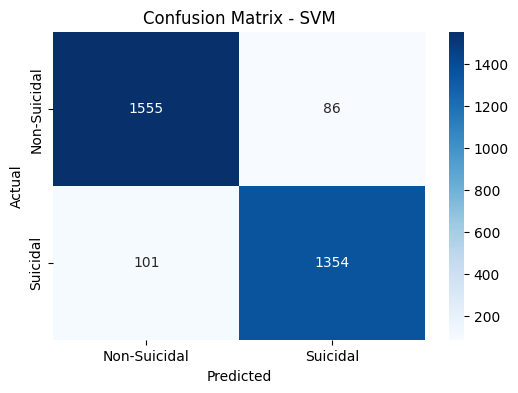

In [34]:
# Fit SVM model
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

# Calculate F1 score & recall score
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print results
print(f"Model: SVM")
print(f"F1 Score (SVM): {f1:.4f}")
print(f"Recall Score (SVM): {recall:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Suicidal', 'Suicidal'], yticklabels=['Non-Suicidal', 'Suicidal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

# Efforts to Improve F1 Scores & Recall Scores

In [35]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [36]:
# Redefine model
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Naive Bayes': MultinomialNB(),
}

Model: Logistic Regression
Optimal Threshold: 0.48
Average F1 Score (5-Fold): 0.9416
Average Recall Score (5-Fold): 0.9402
Classification Report:
{'precision': 0.9430052868588333, 'recall': 0.9402061855670103, 'f1-score': 0.9415895236992657}
Confusion Matrix:


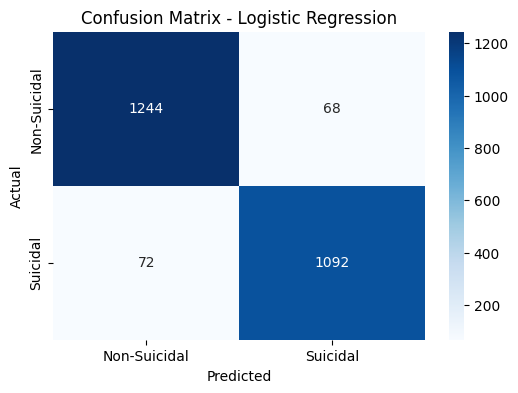

Model: Naive Bayes
Optimal Threshold: 0.38
Average F1 Score (5-Fold): 0.9250
Average Recall Score (5-Fold): 0.9320
Classification Report:
{'precision': 0.9184548956160221, 'recall': 0.9319587628865978, 'f1-score': 0.9249556758166928}
Confusion Matrix:


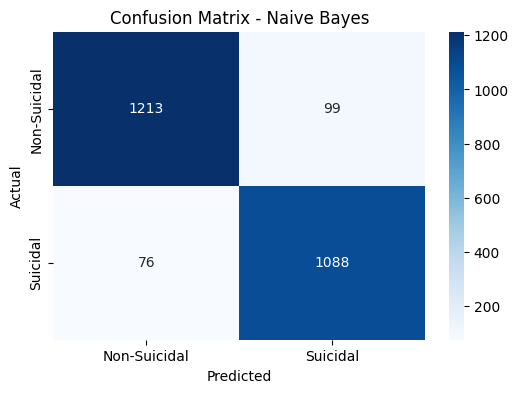

In [37]:
# Perform K-Fold Validation and Evaluate Models
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store model results
results = {}

for name, model in models.items():
    f1_scores, recall_scores = [], []
    all_classification_report = []
    last_cm = None
    best_thresholds = []

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train_bal[train_index], X_train_bal[test_index]
        y_train_fold, y_test_fold = y_train_bal.iloc[train_index], y_train_bal.iloc[test_index]

        # Fit the model
        model.fit(X_train_fold, y_train_fold)

        # Make predictions
        y_pred_fold = model.predict(X_test_fold)

        # Predict probabilities for threshold tuning
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_fold)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test_fold)

        # Find the optimal threshold using Precision-Recall Curve
        precision, recall, thresholds = precision_recall_curve(y_test_fold, y_pred_proba)
        f1_scores_curve = (2 * precision * recall) / (precision + recall)
        best_threshold = thresholds[np.argmax(f1_scores_curve)]
        best_thresholds.append(best_threshold)

        # Apply the best threshold to make final predictions
        y_pred_fold = (y_pred_proba >= best_threshold).astype(int)

        # Calculate F1 score & recall score
        f1 = f1_score(y_test_fold, y_pred_fold)
        f1_scores.append(f1)
        recall = recall_score(y_test_fold, y_pred_fold)
        recall_scores.append(recall)

        # Store classification report for analysis
        report = classification_report(y_test_fold, y_pred_fold, output_dict=True)
        if all_classification_report is None:
          all_classification_report = report
        else:
          all_classification_report.append(report)

        # Store last confusion matrix
        last_cm = confusion_matrix(y_test_fold, y_pred_fold)

    # Calculate mean F1 score & recall score
    mean_f1 = np.mean(f1_scores)
    mean_recall = np.mean(recall_scores)
    avg_threshold = np.mean(best_thresholds)

    # Average classification report
    avg_report = {
      'precision': np.mean([r['1']['precision'] for r in all_classification_report]),
      'recall': np.mean([r['1']['recall'] for r in all_classification_report]),
      'f1-score': np.mean([r['1']['f1-score'] for r in all_classification_report])
    }

    # Store results
    results[name] = {
        'F1 score': mean_f1,
        'Recall': mean_recall,
        'Classification report': avg_report,
        'Threshold': avg_threshold
    }

    # Print results
    print(f"Model: {name}")
    print(f"Optimal Threshold: {avg_threshold:.2f}")
    print(f"Average F1 Score (5-Fold): {mean_f1:.4f}")
    print(f"Average Recall Score (5-Fold): {mean_recall:.4f}")
    print("Classification Report:")
    print(avg_report)
    print("Confusion Matrix:")

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(last_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Suicidal', 'Suicidal'], yticklabels=['Non-Suicidal', 'Suicidal'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

In [38]:
# Redefine SVM model
svm = SVC(kernel='linear', class_weight='balanced', probability = True)

Model: SVM
Optimal Threshold: 0.48
F1 Score (SVM): 0.9364
Recall Score (SVM): 0.9368
Classification Report:
              precision    recall  f1-score   support

           0      0.944     0.943     0.944      1641
           1      0.936     0.937     0.936      1455

    accuracy                          0.940      3096
   macro avg      0.940     0.940     0.940      3096
weighted avg      0.940     0.940     0.940      3096

Confusion Matrix:


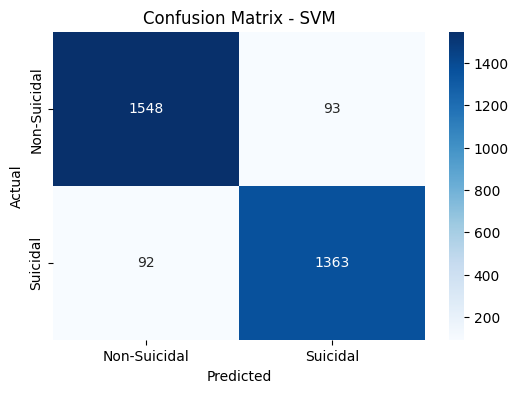

In [39]:
# Fit the model
svm.fit(X_train_bal, y_train_bal)

# Make predictions
y_pred = svm.predict(X_test)

# Predict probabilities for the positive class
y_prob = svm.predict_proba(X_test)[:, 1]

# Generate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Find the optimal threshold by maximizing the F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[f1_scores.argmax()]

# Apply the best threshold to make final predictions
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Calculate F1 score & recall score
f1 = f1_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)

# Print results
print(f"Model: SVM")
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"F1 Score (SVM): {f1:.4f}")
print(f"Recall Score (SVM): {recall:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_optimal, digits=3))
print("Confusion Matrix:")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Suicidal', 'Suicidal'], yticklabels=['Non-Suicidal', 'Suicidal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

# Model Deployment

In [40]:
import joblib

# Select the best model
best_model_name = "Logistic Regression"
best_model = models[best_model_name]
best_threshold = results[best_model_name]['Threshold']

# Save the best model
joblib.dump(best_model, "best_model.pkl")
print(f"Saved {best_model_name} as best_model.pkl")

# Save the optimal threshold
joblib.dump(best_threshold, "best_threshold.pkl")

# Save the TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("Saved TF-IDF vectorizer as tfidf_vectorizer.pkl")

# Save the metadata scaler
joblib.dump(scaler, "metadata_scaler.pkl")
print("Saved metadata scaler as metadata_scaler.pkl")

# Save the Word2Vec model
joblib.dump(word2vec_model, "word2vec_model.pkl")
print("Saved Word2Vec model as word2vec_model.pkl")

# Save the GloVe embeddings
joblib.dump(glove_embeddings, "glove_embeddings.pkl")
print("Saved GloVe embeddings as glove_embeddings.pkl")

Saved Logistic Regression as best_model.pkl
Saved TF-IDF vectorizer as tfidf_vectorizer.pkl
Saved metadata scaler as metadata_scaler.pkl
Saved Word2Vec model as word2vec_model.pkl
Saved GloVe embeddings as glove_embeddings.pkl
